<center><h1>DSCI-552 HOMEWORK 4-Part2</h1><center>
<br>
<center><font size="4"></font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")

import os
import urllib
import pandas as pd
# from tqdm import tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix, accuracy_score, classification_report


# check the environment
print (os.environ['CONDA_DEFAULT_ENV'])

dsci552


# 2. Tree-Based Methods

## 2(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
# define file names
trainfile = "../data/aps_failure_training_set.csv"
testfile = "../data/aps_failure_test_set.csv"
descriptionfile = "../data/aps_failure_description.txt"

Note: since these data files have been downloaded do not need to run the code below

In [3]:
# # download original dataset 
# url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_training_set.csv"
# url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_test_set.csv"
# url_description = "https://archive.ics.uci.edu/ml/machine-learning-databases/00421/aps_failure_description.txt"

# urllib.request.urlretrieve(url_train, trainfile)
# urllib.request.urlretrieve(url_test, testfile)
# urllib.request.urlretrieve(url_description, descriptionfile)

## 2(b) Data Preparation 
## This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea. 
### 2(b)(i) Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [4]:
train_data_original =  pd.read_csv(trainfile, sep=",", na_values= 'na', skiprows=20)
test_data_original =  pd.read_csv(testfile, sep=",", na_values= 'na', skiprows=20)

print("Training data shape: ",train_data_original.shape)
print("Test data shape: ",test_data_original.shape)

Training data shape:  (60000, 171)
Test data shape:  (16000, 171)


In [5]:
# missing_ratio 
train_missing_ratio = train_data_original.apply(lambda x : sum(x.isna()) / len(x), axis=0)
test_missing_ratio = test_data_original.apply(lambda x : sum(x.isna()) / len(x), axis=0)
print("Training Data Missing Ratio: \n", train_missing_ratio.loc[train_missing_ratio != 0])
print("="*30)
print("Test Data Missing Ratio: \n", test_missing_ratio.loc[test_missing_ratio != 0])

Training Data Missing Ratio: 
 ab_000    0.772150
ac_000    0.055583
ad_000    0.247683
ae_000    0.041667
af_000    0.041667
            ...   
ee_007    0.011183
ee_008    0.011183
ee_009    0.011183
ef_000    0.045400
eg_000    0.045383
Length: 169, dtype: float64
Test Data Missing Ratio: 
 ab_000    0.772687
ac_000    0.057875
ad_000    0.248812
ae_000    0.043125
af_000    0.043125
            ...   
ee_007    0.012000
ee_008    0.012000
ee_009    0.012000
ef_000    0.047625
eg_000    0.047625
Length: 169, dtype: float64


In [6]:
# define a function to split X and y
def xy_split(dataset):
    
    X = dataset.iloc[:,1:]
    y = dataset.iloc[:,0]
    
    return X, y

In [7]:
# define a function to label y
def make_label(y):
    
    lb = preprocessing.LabelBinarizer(neg_label=-1, pos_label=1)
    y = lb.fit_transform(y)
    
    return(y)

This part is used for determine the best imputation method:
Does not need to run

In [8]:
# Perform data imputation test on training set to say which one is better
# X, y = xy_split(train_data_original)
# y= label(y)
# model = RandomForestClassifier(n_jobs=-1)
# results = []
# skf = StratifiedKFold(n_splits=5,shuffle=True, random_state= 42)
# strategies = ['mean', 'median', 'most_frequent', 'constant']
# for s in tqdm(strategies):
#     pipeline = Pipeline([('impute', SimpleImputer(missing_values=np.nan,strategy=s)),('model', model)])
#     scores = cross_val_score(pipeline, X.values, y, scoring='accuracy', cv=skf, n_jobs=-1)
#     results.append(scores)

# pipeline2 = Pipeline([('impute', IterativeImputer(random_state=42, missing_values=np.nan)),('model', model)])
# score2 = cross_val_score(pipeline, X.values, y, scoring='accuracy', cv=skf, n_jobs=-1)

# for method, score in zip(strategies, results):
#     print('Method: SimpleImputer-{0}, accuracy score: = {1:.4f}, max accuracy: {2:.4f}'.format(method, np.mean(score), np.max(score)))
# print('Method: {0}, accuracy score: = {1:.4f}, max accuracy: {2:.4f}'.format('IterativeImputer', np.mean(score2), np.max(score)))

In [9]:
# Imputation Using scikit-learn SimpleImputer :
def impute_simple(tr, ts, strategy):
    '''
    strategies = ['mean', 'median', 'most_frequent', 'constant']

    '''
    X_tr, y_tr = xy_split(tr)
    X_ts, y_ts = xy_split(ts)
    
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(X_tr.values)
    imputed_X_tr = pd.DataFrame(imp.transform(X_tr.values), columns=X_tr.columns, index=y_tr.index)
    imputed_X_ts = pd.DataFrame(imp.transform(X_ts.values), columns=X_ts.columns, index=y_ts.index)
    
    imputed_tr = pd.concat([y_tr, imputed_X_tr], axis=1)
    imputed_ts = pd.concat([y_ts, imputed_X_ts], axis=1)
    
    return imputed_tr, imputed_ts

In [10]:
# Imputation Using scikit-learn IterativeImputer :
def impute_iterative(tr, ts, estimator):
    '''estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
    ]
    '''
    
    X_tr, y_tr = xy_split(tr)
    X_ts, y_ts = xy_split(ts)
    
    imp = IterativeImputer(estimator=estimator, random_state=42, missing_values=np.nan, max_iter=100)
    imp.fit(X_tr.values)
    imputed_X_tr = pd.DataFrame(imp.transform(X_tr.values), columns=X_tr.columns, index=y_tr.index)
    imputed_X_ts = pd.DataFrame(imp.transform(X_ts.values), columns=X_ts.columns, index=y_ts.index)
    
    imputed_tr = pd.concat([y_tr, imputed_X_tr], axis=1)
    imputed_ts = pd.concat([y_ts, imputed_X_ts], axis=1)
    
    return imputed_tr, imputed_ts

Note: I use mode as the imputation strategy the reason is the same as part 1. Some columns are missing 80% data, mean strategy sometimes create huge bias, I will use mode

In [11]:
%%time
# perform data imputation 
imputed_train, imputed_test = impute_simple(train_data_original, test_data_original, 'most_frequent')
# imputed_train, imputed_test = impute_iterative(train_data_original, test_data_original, BayesianRidge())
imputed_data = imputed_train.append(imputed_test, ignore_index=True)
print("Number of Missing Data: ", imputed_data.isna().sum().sum())
imputed_data.head()

Number of Missing Data:  0
Wall time: 561 ms


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698.0,0.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040.0,0.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874.0,0.0,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### 2(b)(ii). For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [12]:
#define function to calculate cv
CV = lambda x: np.std(x, ddof=1) / np.mean(x)
#calculate CV for each column in data frame
COV = imputed_data.iloc[:,1:].apply(CV)
print(COV)

aa_000      4.328608
ab_000      9.740521
ac_000      2.309299
ad_000    274.867354
ae_000     23.271357
             ...    
ee_007      4.942369
ee_008      3.375044
ee_009      5.821008
ef_000     50.223681
eg_000     47.845392
Length: 170, dtype: float64


### 2(b)(iii). Plot a correlation matrix for your features using pandas or any other tool.

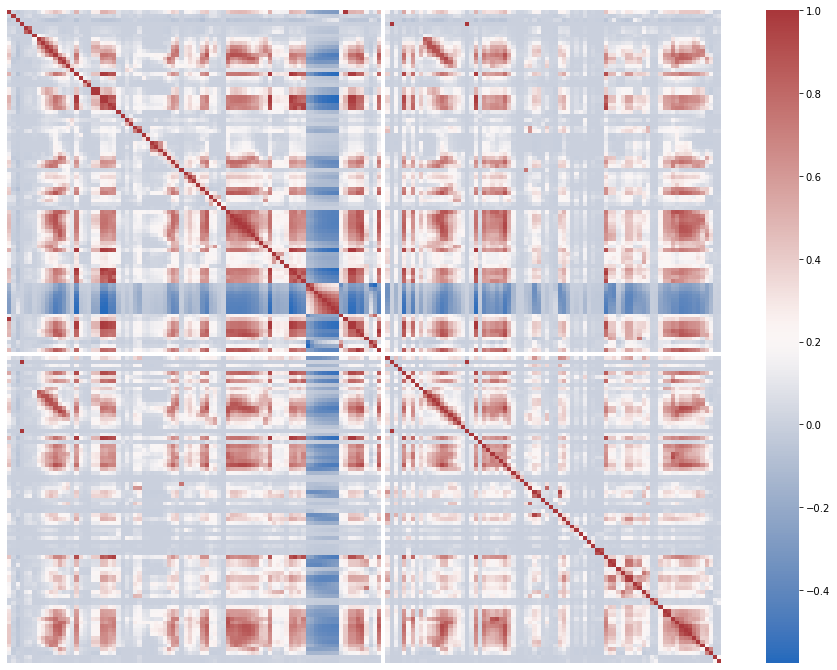

In [13]:
# Compute the correlation matrix
corrMatrix=imputed_data.iloc[:,1:].corr()
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corrMatrix, cmap='vlag',  xticklabels=False, yticklabels=False)

### 2(b)(iv). Pick $\left \lfloor \sqrt{170} \right \rfloor$ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [14]:
num_features = floor(sqrt(170))
highest_cv = COV.sort_values(ascending=False)[:num_features]
print(highest_cv)

cf_000    275.597029
co_000    275.072957
ad_000    274.867354
cs_009    194.720937
dj_000    130.915233
dh_000    120.759504
df_000    119.384411
as_000    115.082077
ag_000     92.507510
au_000     86.992248
ak_000     84.875146
az_009     78.895508
ay_009     78.350868
dtype: float64


In [15]:
# select the highest_cv features also with the class as hue
highest_features = list(highest_cv.index)
select_features = highest_features.copy()
select_features.append("class")
df_select = imputed_data[select_features]

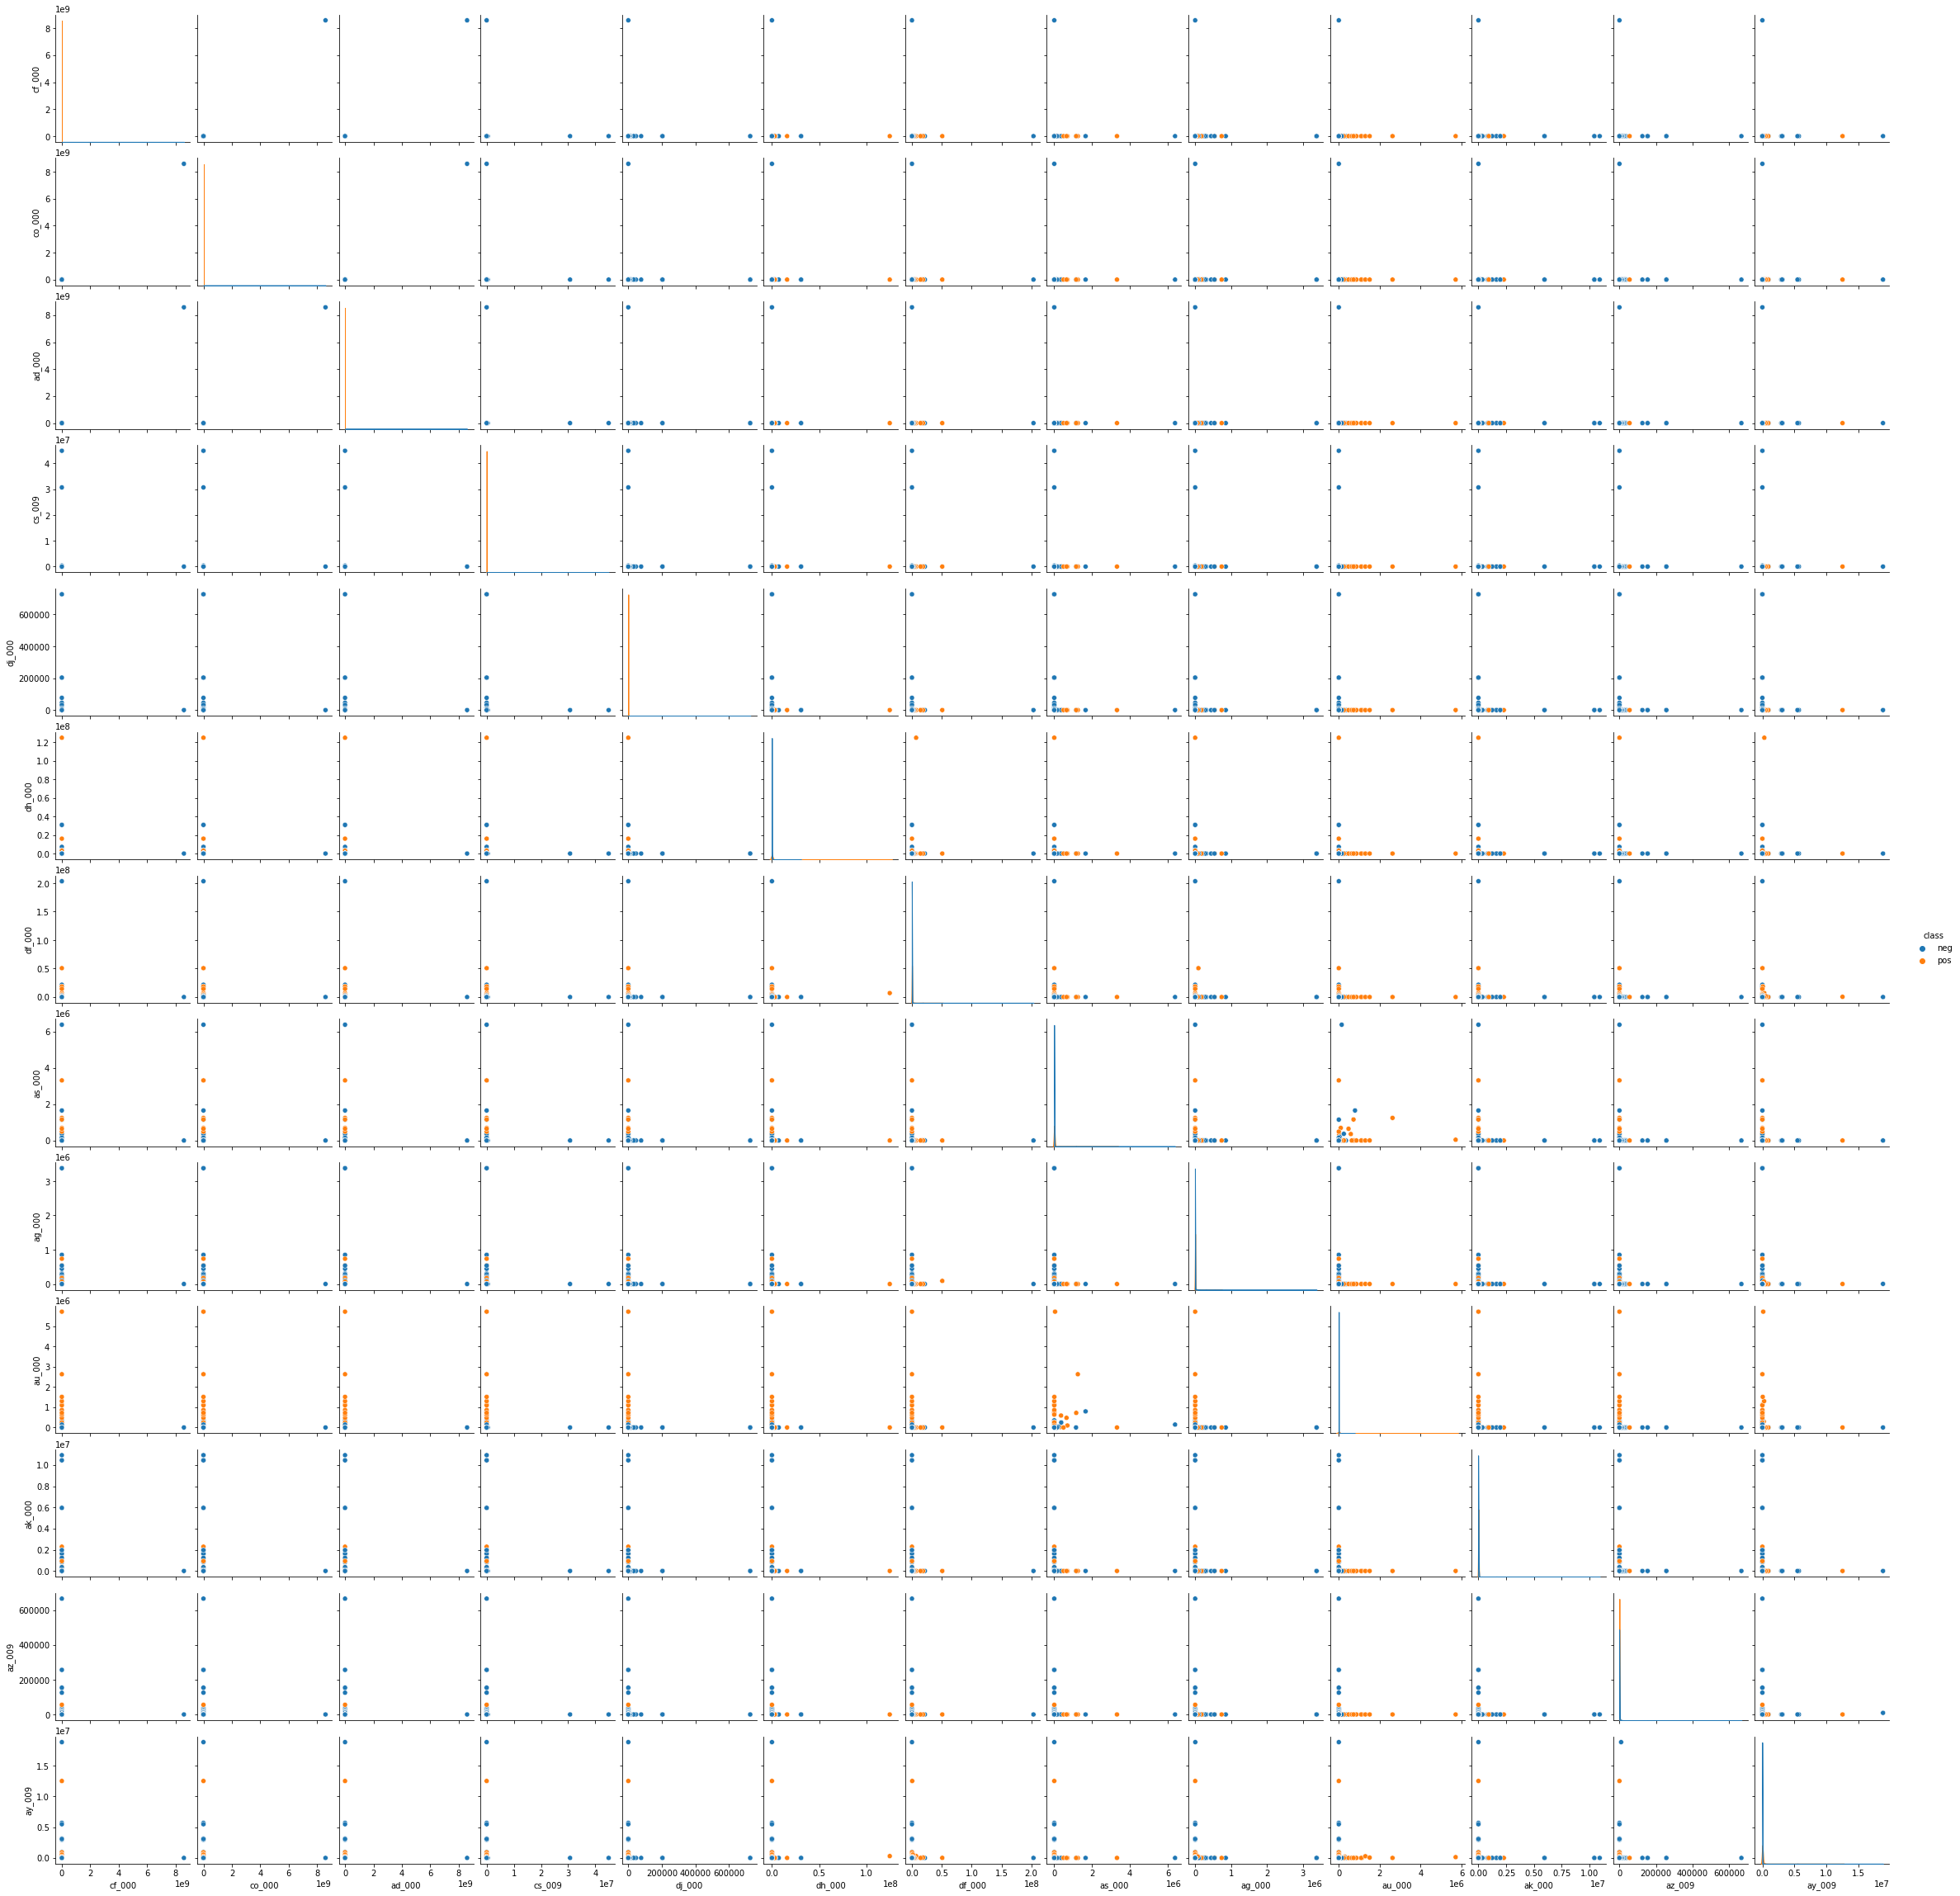

Wall time: 5min 56s


In [16]:
%%time
# This part takes about 6 min
g = sns.pairplot(df_select, diag_kind='kde', hue = 'class')
plt.show()

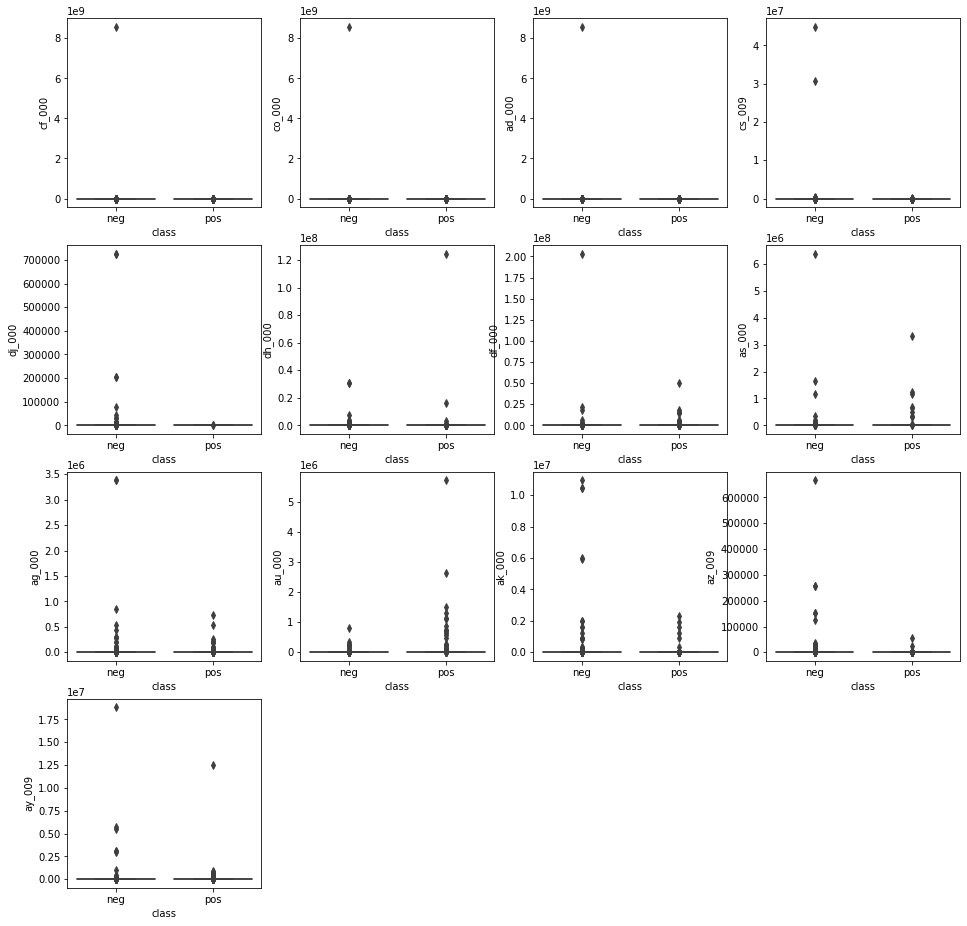

In [17]:
fig, ax = plt.subplots(figsize=(16,16))
i=1
names = df_select.columns[:-1]
for name in names:
    plt.subplot(4,4,i)
    
    g=sns.boxplot(y=name, x="class", data=df_select)
#     g.set_xlabel("Class(Neg, Pos)")
    g.set_ylabel(name)
    i+=1

<strong>Answer</strong><br>
* Based on the pair plot, it seems like there is no correlation between each feature
* The boxplot indicates there is no significant different between two classes. The reason could be too many outliers

### 2(b)(v). Determine the number of positive and negative data. Is this data set imbalanced?

In [18]:
print("Training Data class count: \n", imputed_train['class'].value_counts())
print("="*30)
print("Test Data class count: \n", imputed_test['class'].value_counts())

Training Data class count: 
 neg    59000
pos     1000
Name: class, dtype: int64
Test Data class count: 
 neg    15625
pos      375
Name: class, dtype: int64


<strong>Answer</strong><br>
The training data set is obviously imbalanced

## 2(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.
ref: https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

In [19]:
def dataPreprocess(tr, ts, label=True):
    
    X_train, y_train = xy_split(tr)
    X_test, y_test = xy_split(ts)
    
    if label==True:
    
        y_train = make_label(y_train).ravel()
        y_test = make_label(y_test).ravel()

        return X_train, X_test, y_train, y_test
    else:
        return X_train, X_test, y_train, y_test

In [20]:
# define confusion matix function
def cm(model, X, y_true, y_predict, title_option):
    '''
    Example: title_option : 'Training', 'Test'

    '''
    print(confusion_matrix(y_true, y_predict))
    # plot confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    plot_confusion_matrix(model, X, y_true, cmap=plt.cm.viridis, ax=ax) 
    
    ax.set_xlabel('Predict-label',fontsize=12)
    ax.set_ylabel('True-label',fontsize=12)
    ax.set_xticklabels(['Neg', 'Pos'])
    ax.set_yticklabels(['Neg', 'Pos'])
    ax.set_title("{} Data Confustion Matrix".format(title_option), fontsize=16)

        
    plt.show()
    
    class_report = classification_report(y_true, y_predict, target_names=['Neg', 'Pos'])

    print("-"*55)
    print("Report for Model: ")
    print("-"*55)
    print(class_report)
    print("-"*55)

In [21]:
# define roc curve function
def roc(y_true, y_score, title_option):
    '''
    Example: title_option : 'Training', 'Test'

    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.grid()
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("{} Data ROC curve".format(title_option))
    plt.show()
    print("AUC is" , roc_auc)

In [22]:
# define training and testing data
X_train, X_test, y_train, y_test = dataPreprocess(imputed_train, imputed_test, label=True)

In [23]:
# declare random forest parameters
# called out some parameters to increase the speed if need 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_depth = [1,3,5] 
max_depth.append(None)
min_samples_split = [2]  
max_features = ['auto']
min_samples_leaf = [1]   
max_leaf_nodes = [int(x) for x in np.linspace(10, 50, num = 5)]
max_leaf_nodes.append(None)

# Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators, # The number of trees
               'max_depth': max_depth, #The maximum depth of the tree
               'min_samples_split': min_samples_split, # Minimum number of samples required to split a node
               'min_samples_leaf': min_samples_leaf,  # Minimum number of samples required at each leaf node
               'max_leaf_nodes': max_leaf_nodes,
               'max_features': max_features, # Number of features to consider at every split p^(1/2)
               }

In [24]:
%%time
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle = True, random_state= 42)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle = True, random_state= 42)
# Create base model to tune
rf = RandomForestClassifier(oob_score=True, n_jobs=-1) #set to true in order to return oob_score
# Create random search model and fit the data
rf_random = RandomizedSearchCV(
                        estimator = rf,
                        param_distributions = random_grid,
                        n_iter = 10, 
                        cv = skf,
                        verbose=0, 
                        random_state=42, 
                        scoring='accuracy', 
                        n_jobs=-1)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_ # return the best model
print(rf_random.best_params_)

{'n_estimators': 344, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 50, 'max_features': 'auto', 'max_depth': None}
Wall time: 2min 34s


#### - Training Data

[[58975    25]
 [  292   708]]


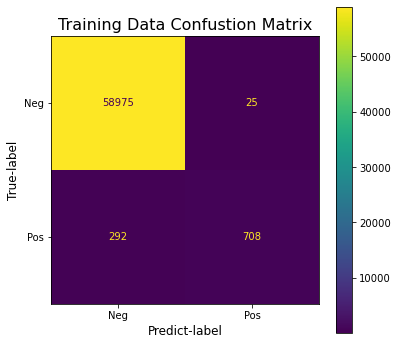

-------------------------------------------------------
Report for Model: 
-------------------------------------------------------
              precision    recall  f1-score   support

         Neg       1.00      1.00      1.00     59000
         Pos       0.97      0.71      0.82      1000

    accuracy                           0.99     60000
   macro avg       0.98      0.85      0.91     60000
weighted avg       0.99      0.99      0.99     60000

-------------------------------------------------------


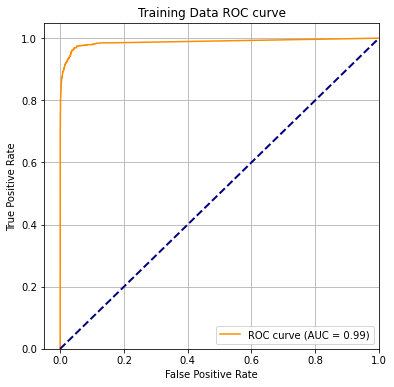

AUC is 0.9877147966101695
Misclassification for training set:  0.005283333333333307


In [25]:
# Predict y_train and 
y_train_pred_2c = best_rf.predict(X_train)
y_train_score_2c = best_rf.predict_proba(X_train)[:,1]
train_error_2c = 1-accuracy_score(y_train, y_train_pred_2c)

# Plot confusion matrix and roc curve
cm(best_rf, X_train, y_train, y_train_pred_2c, 'Training')
roc(y_train, y_train_score_2c, 'Training')
print("Misclassification for training set: ", train_error_2c)

#### - Test Data

[[15612    13]
 [  139   236]]


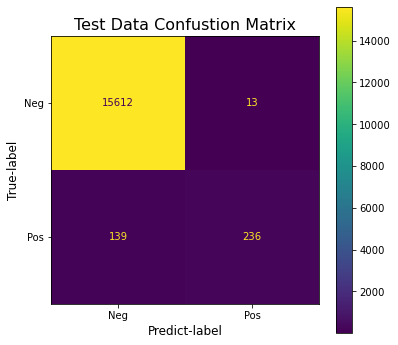

-------------------------------------------------------
Report for Model: 
-------------------------------------------------------
              precision    recall  f1-score   support

         Neg       0.99      1.00      1.00     15625
         Pos       0.95      0.63      0.76       375

    accuracy                           0.99     16000
   macro avg       0.97      0.81      0.88     16000
weighted avg       0.99      0.99      0.99     16000

-------------------------------------------------------


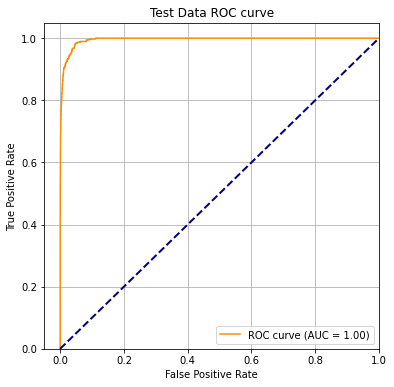

AUC is 0.9950180693333333
Misclassification for test set:  0.009499999999999953


In [26]:
# Predict y_test and plot confusion matrix and roc curve
y_test_pred_2c = best_rf.predict(X_test)
y_test_score_2c = best_rf.predict_proba(X_test)[:,1]
test_error_2c = 1-accuracy_score(y_test, y_test_pred_2c)

# Plot confusion matrix and roc curve
cm(best_rf, X_test, y_test, y_test_pred_2c, 'Test')
roc(y_test, y_test_score_2c, 'Test')
print("Misclassification for test set: ", test_error_2c )

#### - Compare Error Result

In [27]:
oob_error = 1-best_rf.oob_score_

print("The Out-of-Bag Error is: ", oob_error)
print("The Test Error is: ", test_error_2c)

The Out-of-Bag Error is:  0.007499999999999951
The Test Error is:  0.009499999999999953


<strong>Answer</strong><br>
* The test error is higher than out-of-bag error. 
* The out-of-bag error is the average of remaining of the observations not used to fit a given bagged tree as validation set during training process. 
* The out-of-bag error has to be minimized to decrease the bias during training process, on ther other hand the lower the training error, the variance increased so the test error can be larger than oob error.

## 2(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

In [28]:
%%time
# Create base model to tune
rf2 = RandomForestClassifier(oob_score=True, class_weight = 'balanced', n_jobs=-1) 
# Create random search model and fit the data
rf_random2 = RandomizedSearchCV(
                        estimator = rf2,
                        param_distributions = random_grid,
                        n_iter = 10, 
                        cv = skf,
                        verbose=0, 
                        random_state=42, 
                        scoring='accuracy', 
                        n_jobs=-1)

rf_random2.fit(X_train, y_train)
best_rf2 = rf_random2.best_estimator_ # return the best model
print(rf_random2.best_params_)

{'n_estimators': 344, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 50, 'max_features': 'auto', 'max_depth': None}
Wall time: 3min


#### - Training Data

[[57371  1629]
 [   19   981]]


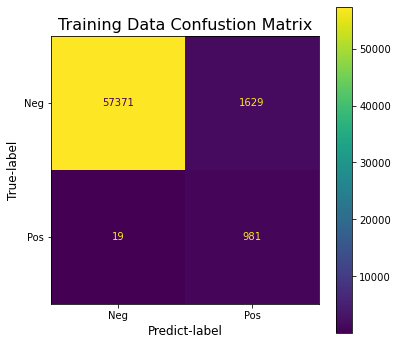

-------------------------------------------------------
Report for Model: 
-------------------------------------------------------
              precision    recall  f1-score   support

         Neg       1.00      0.97      0.99     59000
         Pos       0.38      0.98      0.54      1000

    accuracy                           0.97     60000
   macro avg       0.69      0.98      0.76     60000
weighted avg       0.99      0.97      0.98     60000

-------------------------------------------------------


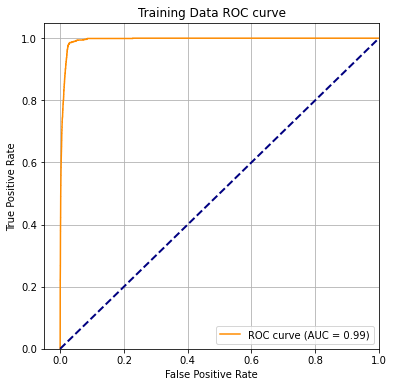

AUC is 0.9941436186440678
Misclassification for training set:  0.02746666666666664


In [29]:
# Predict y_train and plot confusion matrix and roc curve
y_train_pred_2d = best_rf2.predict(X_train)
y_train_score_2d = best_rf2.predict_proba(X_train)[:,1] 
train_error_2d = 1-accuracy_score(y_train, y_train_pred_2d)

# Plot confusion matrix and roc curve
cm(best_rf2, X_train, y_train, y_train_pred_2d, 'Training')
roc(y_train, y_train_score_2d, 'Training')
print("Misclassification for training set: ", train_error_2d)

#### - Test Data

[[15202   423]
 [   22   353]]


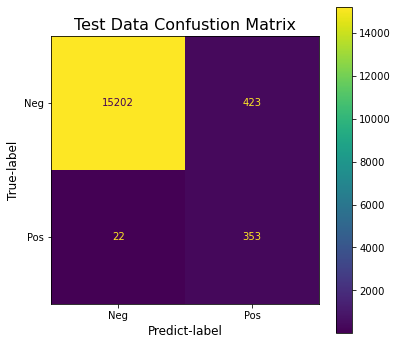

-------------------------------------------------------
Report for Model: 
-------------------------------------------------------
              precision    recall  f1-score   support

         Neg       1.00      0.97      0.99     15625
         Pos       0.45      0.94      0.61       375

    accuracy                           0.97     16000
   macro avg       0.73      0.96      0.80     16000
weighted avg       0.99      0.97      0.98     16000

-------------------------------------------------------


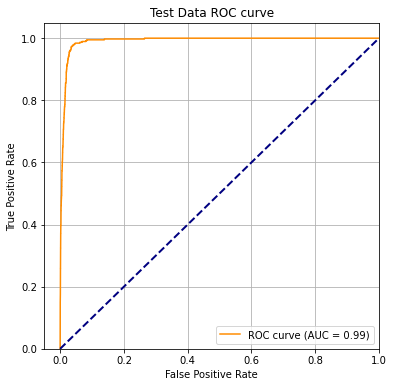

AUC is 0.9906885973333333
Misclassification for test set:  0.02746666666666664


In [30]:
# Predict y_test and plot confusion matrix and roc curve
y_test_pred_2d = best_rf2.predict(X_test)
y_test_score_2d = best_rf2.predict_proba(X_test)[:,1] 
test_error_2d = 1-accuracy_score(y_train, y_train_pred_2d)

cm(best_rf2, X_test, y_test, y_test_pred_2d, 'Test')
roc(y_test, y_test_score_2d, 'Test')
print("Misclassification for test set: ", test_error_2d)

#### - Compare Error Result

In [31]:
oob_error2 = 1-best_rf2.oob_score_

print("The Out-of-Bag Error is: ", oob_error2)
print("The Test Error is: ", test_error_2d)

The Out-of-Bag Error is:  0.02905000000000002
The Test Error is:  0.02746666666666664


#### - Compare 2d result with 2c

In [32]:
model_list = ['imbalanced', 'imbalance-compensate']
oob_error_list = [oob_error, oob_error2]
test_error_list = [test_error_2c, test_error_2d]
df_summary = pd.DataFrame({'Model': model_list, 
                           'oob_error':oob_error_list, 
                           'test_error': test_error_list})
df_summary

,Model,oob_error,test_error
0,imbalanced,0.00750,0.009500
1,imbalance-compensate,0.02905,0.027467


* Comparing both imbalance and imbalance-compensating results, the Out-of-Bag error and test error of are imbalance-compensating results are increased.
* The AUC of imbalance-compensating result is slightly dropped
* The above result is reasonable, since the imbalance-compensating results increase the recall score for 'pos' label, it has to reduce the accuracy and reduce the TPR as the trade off. So the model can have a better prediction on 'pos' label case

## 2(e) Model Trees - Preparation ( 2(e) and 2(f) is in HW4_part3 Notebook)
ref: http://fracpete.github.io/python-weka-wrapper/examples.html <br>
ref: http://fracpete.github.io/python-weka-wrapper/api.html#experiments <br>
ref: https://fracpete.github.io/python-weka-wrapper3/examples.html#cross-validate-filtered-classifier-and-print-evaluation-and-display-roc

In [33]:
# save the imputed data in csv file, then it is easy for weka to load by weka loader
X_train, X_test, y_train_str, y_test_str = dataPreprocess(imputed_train, imputed_test, label=False)
tr = pd.concat([X_train, y_train_str], axis=1)
ts = pd.concat([X_test, y_test_str], axis=1)

weka_train_file = '../data/weka_train.csv'
weka_test_file = '../data/weka_test.csv'

tr.to_csv(weka_train_file, index=False)
ts.to_csv(weka_test_file, index=False)